In [1]:
%matplotlib notebook
import numpy as np
from scipy.stats import kde
from scipy.ndimage.filters import gaussian_filter
import pandas as pd
import os
import shutil
import subprocess
from subprocess import Popen
import datetime
import matplotlib.pyplot as plt  # plotting
import xlrd

from decimal import Decimal

from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
from scipy.stats import binned_statistic_2d

# make prefix for figure filenames
now = datetime.datetime.now()
date = now.strftime('%Y%m%d')
pref = date

In [2]:
# membrane_path = '../actincme/pkl_files/'

# generally we only want to plot the first membrane object
membrane_object = 1

# set normal_directionality based on whether the normal_vector is pointing such that a similarly oriented filament would have an angle of 0 (1) or 180 (-1)

# membrane_path = '2018August_Tomo27/'
# # if the membrane object to plot is not 1
# membrane_object = 45
# normal_directionality = -1

# membrane_path = '2018_April_Tomo01/'
# normal_directionality = 1

# membrane_path = '2018June_Tomo14_Early_Invagination/'
# normal_directionality = 1

# membrane_path = '2018June_Tomo14_Late_Invagination/'
# normal_directionality = -1

membrane_path = '2018June_Tomo26/'
normal_directionality = -1 

# # NOTE 2018march does not have unbranched filaments
# membrane_path = '2018March/'
# normal_directionality = 1

# membrane_path = '2018November_32/'
# normal_directionality = 1

In [3]:
# branched filaments file
branched_filaments_file = []
unbranched_filaments_file = []
membranefilename = []
nogoplane_name = []

files_in_dir = os.listdir(membrane_path)
for file in files_in_dir:
    if 'Branched' in file and 'txt' in file:
        branched_filaments_file = file

for file in files_in_dir:
    if 'Unbranched' in file and 'txt' in file:
        unbranched_filaments_file = file
        
# membrane file

for file in files_in_dir:
    if "embrane" in file or "CoatedVesicle" in file:
        membranefilename = file

# Find unbranched filaments orientation file
for file in files_in_dir:
    if "rientation" in file and 'xls' in file:
        orientation_info_file = file

# find nogo file 
for file in files_in_dir:
    if "eference" in file and "lane.txt" in file:
        nogoplane_name = file
        
membranefilename

'Membrane_2018June_Tomo26_CME_Invagination.txt'

In [4]:
# read in the unbranched filament orientation file
excelfile = pd.read_excel(membrane_path+ orientation_info_file)

# branched filaments
actinfile1 = membrane_path+branched_filaments_file

# unbranched filaments
actinfile2 = membrane_path + unbranched_filaments_file

# nogo plane
nogoplane = membrane_path + nogoplane_name
# membrane
membranefile = membrane_path + membranefilename
excelfile

,Contour Number In Model,Plus-end,Minus-end,Average difference
0,2,10,1,0.17
1,5,1,10,-0.14
2,6,6,1,0.37
3,7,1,8,0.21
4,9,1,11,0.22
5,13,1,8,0.14
6,14,1,10,0.23
7,16,1,10,-0.16
8,17,1,21,0.17
9,19,1,11,0.20


In [5]:
# more manual way of finding the filex

# # working_dir = os.curdir
# actinfile1 = '2018June_Tomo26/UnbranchedActin_2018June_Tomo26_CME_Invagination.txt'
# actinfile2 = '2018June_Tomo26/BranchedActin_2018June_Tomo26_CME_Invagination.txt'
# membranefile = '2018June_Tomo26/Membrane_2018June_Tomo26_CME_Invagination.txt'
# #TODO: add in excel file into the code 
# #excelfile = 'placeholder.txt'
# excelfile = pd.read_excel('2018June_Tomo26/UnbranchedFilamentOrientationInfo.xlsx')
# # c = open(membranefile,'r')
# # c.readlines()
# nogoplane = '2018June_Tomo26/Reference_Plane.txt'

In [6]:
data_xls = excelfile
data_xls

#Purpose: Fix differences between folders
if 'Contour Number In Model' in data_xls.columns:
    data_xls = data_xls.rename(columns = {'Contour Number In Model': 'Contour number in model'})

#Purpose: Read unbranched coords txt file into a dataframe which is returned.
def read_text_unbranched_coords(file, label = 'fil'):
    import pandas as pd
    ub_coordsfile =  open(file, 'r')
    coords = pd.read_table(ub_coordsfile, delim_whitespace=True)
    coords.columns = ['Contour number in model', 'X', 'Y', 'Z']
    return coords
# actinfile2 is unbranched filaments
ub_coords = read_text_unbranched_coords(actinfile2)


#Purpose: Merge unbranched coords txt file with dataframe from excel file
def merge_files(unbranched_coords, xls_to_df):
    data_xls = xls_to_df
    merged_ub_coords = data_xls.merge(unbranched_coords)
    merged_ub_coords['X_nm'], merged_ub_coords['Y_nm'], merged_ub_coords['Z_nm'] = 0.06*merged_ub_coords['X'], 0.06*merged_ub_coords['Y'], 0.06*merged_ub_coords['Z']
#   merged_ub_coords = merged_ub_coords[['Contour number in model','X','Y','Z','X_nm','Y_nm','Z_nm','Plus end point','Minus end point','Clear Result (0-1)', \
#               'Filament length (nm)','Comment']]
    return merged_ub_coords
ub_coords
print(ub_coords.columns)
print(data_xls.columns)
merged_df = merge_files(ub_coords, data_xls)
merged_df

#Purpose: Add tag to the merged df
plus_ends = {}
for index, row in merged_df.iterrows():
    if(row['Minus-end'] == 1):
        #print('ya')
        plus_ends[row['Contour number in model']] = 'last'
    else:
        plus_ends[row['Contour number in model']] = 'first'
list_of_ends = []
for index, row in merged_df.iterrows():
    if(plus_ends[row['Contour number in model']] == 'last'):
        list_of_ends += ['first']
    else:
        list_of_ends += ['last']
merged_df['minus end point'] = list_of_ends
merged_df.head(50)
merged_df= merged_df.rename(columns = {'Contour number in model':'contour'})
merged_df

#Purpose: Select certain columns from merged table only
selected = merged_df[['contour', 'X', 'Y', 'Z', 'minus end point']]
selected= selected.rename(columns = {'contour':'fil'})
selected_ub_coords = selected.set_index('fil')
selected_ub_coords

Index(['Contour number in model', 'X', 'Y', 'Z'], dtype='object')
Index(['Contour number in model', 'Plus-end', 'Minus-end',
       'Average difference'],
      dtype='object')


,X,Y,Z,minus end point
fil,,,,
2,984,721,127,first
2,973,744,133,first
2,964,766,140,first
2,956,784,145,first
2,949,799,150,first
...,...,...,...,...
128,1378,338,151,first
130,1469,484,144,first
130,1444,501,148,first


In [7]:
#  read in text file
# for all txt filex

# for a particular txt file


def read_text(file, label='fil'):
    
    import pandas as pd
    coordinatesfile = open(file, 'r')
    
    coords_df = pd.read_table(coordinatesfile, delim_whitespace=True)
#     check if there is an 'object' and 'contour' column (membrane)
    if len(coords_df.columns)==4:
        coords_df.columns=[label, 'X', 'Y', 'Z']
        coords_df=coords_df.set_index([label])
    
    elif len(coords_df.columns)==5:
        coords_df.columns=['object', label, 'X', 'Y', 'Z']
        coords_df=coords_df.set_index(['object', label])
        
    else:
        print("unexpected number of columns!")
#     make multiindex
    coordinatesfile.close()
    return coords_df

actin1 = read_text(actinfile1)
actin2 = read_text(actinfile2)
membrane = read_text(membranefile, 'contour')
# membrane
branched_coords = actin1


In [8]:
#No-Go Plane Definition 
#Taken from here: https://stackoverflow.com/questions/53698635/how-to-define-a-plane-with-3-points-and-plot-it-in-3d
ngplane = read_text(nogoplane)
#ngplane.reset_index()
xvals = ngplane['X'].values
yvals = ngplane['Y'].values
zvals = ngplane['Z'].values
xs = []
ys = []
zs = []


# for i in range(int(xvals.size/2)):
#     a = i+1

# define a plane using any three points from the nogo text file

# e.g. use points 0, 1, and last (-1)

i = 0
j = 1
k =-1

points = [[xvals[i], yvals[i], zvals[i]],
          [xvals[j], yvals[j], zvals[j]], 
          [xvals[k], yvals[k], zvals[k]]]

p0, p1, p2 = points
x0, y0, z0 = p0
x1, y1, z1 = p1
x2, y2, z2 = p2

# calculate vectors between points 0 and 1 (and between 1 and 2)

ux, uy, uz = u = [x1-x0, y1-y0, z1-z0]
vx, vy, vz = v = [x2-x0, y2-y0, z2-z0]

# calcualte cross product

u_cross_v = [uy*vz-uz*vy, uz*vx-ux*vz, ux*vy-uy*vx]

# normal vector as an array

point  = np.array(p0)
normal = np.array(u_cross_v)

d = -point.dot(normal)
xx, yy = np.meshgrid(range(10), range(10))

z = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]
# print(z)

# xs.append(xx)
# ys.append(yy)
# zs.append(z)


# define which mebmrane surface to plot
## object == 1 is the CCP


In [9]:
all_membranes = membrane.reset_index()
CCP = all_membranes[all_membranes['object']==membrane_object]


<IPython.core.display.Javascript object>


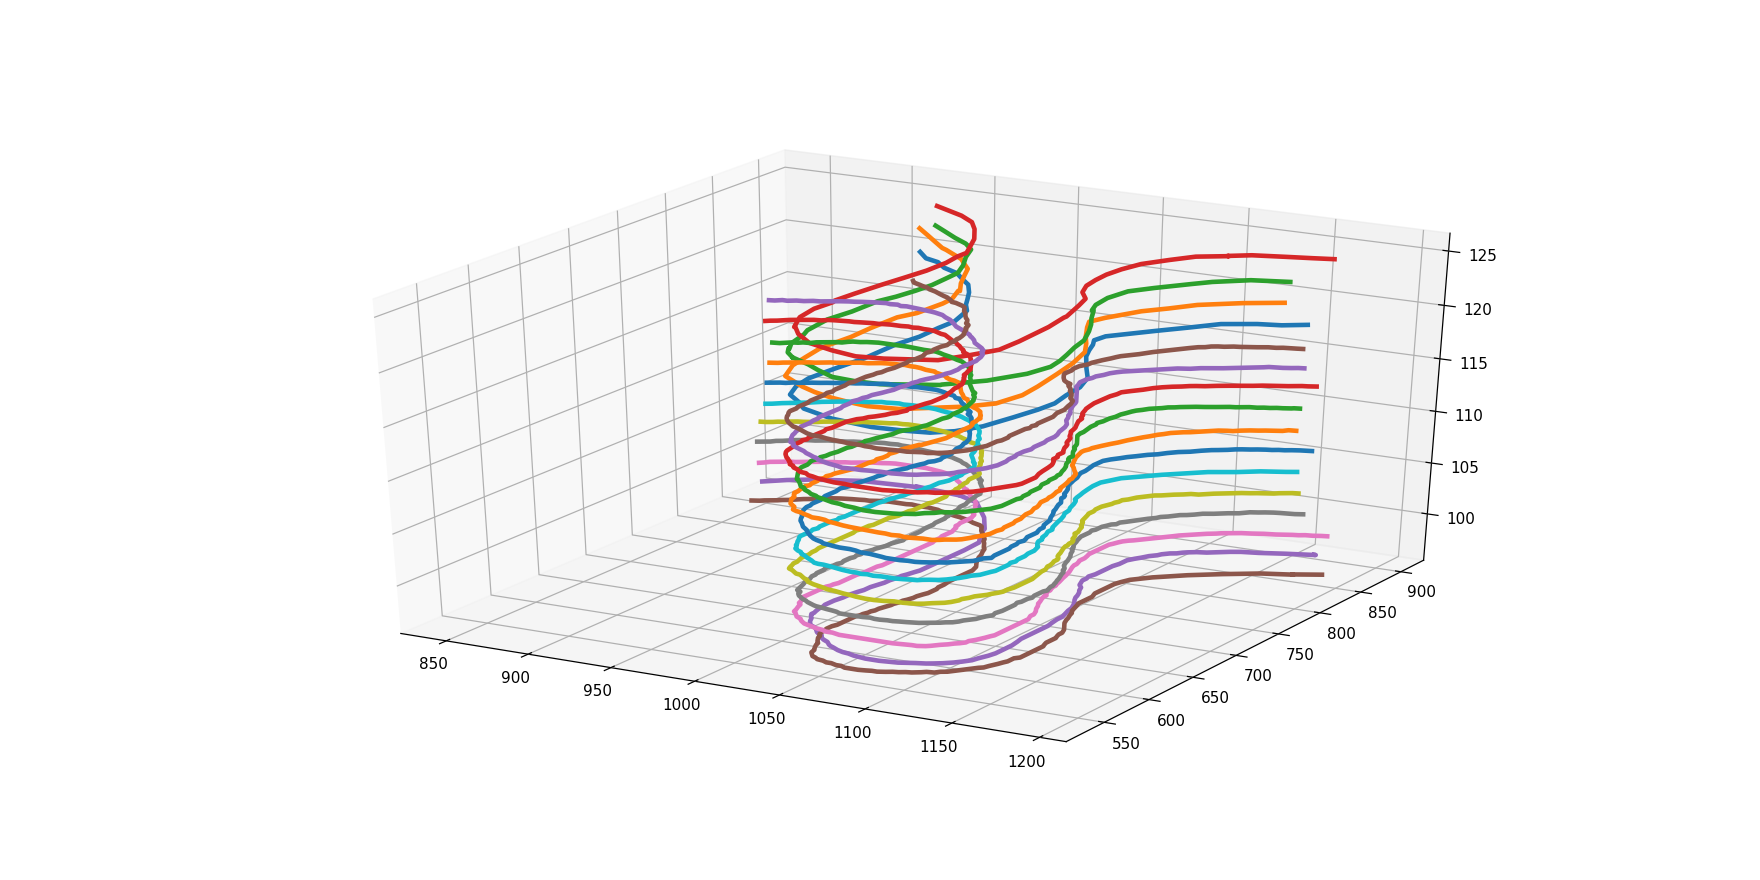

/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/c

In [10]:
# plot membrane

# %matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=[16,8])
ax=fig.add_subplot(111, projection='3d')

for contourr in CCP['contour'].unique():
    cur_contour = CCP[CCP['contour']==contourr]
    ax.plot(xs=cur_contour['X'], ys=cur_contour['Y'], zs=cur_contour['Z'], linewidth=3)

In [58]:
# # plot actin and membrane
# # %matplotlib inline
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(figsize=[10,5])
# ax=fig.add_subplot(111, projection='3d')

# # all_membranes = membrane.reset_index()
# # CCP = all_membranes[all_membranes['object']==1]

# for filament in selected_ub_coords.index.unique():
#     cur_filament = selected_ub_coords[selected_ub_coords.index==filament]
#     ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], linewidth=3,)

# for filament in branched_coords.index.unique():
#     cur_filament = branched_coords[branched_coords.index==filament]
#     ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], linewidth=3)

# for contourr in CCP['contour'].unique():
#     cur_contour = CCP[CCP['contour']==contourr]
#     ax.plot(xs=cur_contour['X'], ys=cur_contour['Y'], zs=cur_contour['Z'], linewidth=3,  linestyle = 'dashed')

# for i in range(int(xvals.size/2)):
#     ax.plot([xvals[i], xvals[i+1]],[yvals[i], yvals[i+1]], zs = [zvals[i], zvals[i+1]])
 


# # plot membrane
# # pit = membranes[membranes['contour']==1]
# # ax.plot(xs = pit['X'], ys=pit['Y'], zs = pit['Z'], linewidth=5)
# # ax.autoscale(enable=True,tight=True) 

# # plt.xlim([500,1400])
# # plt.ylim([350,950])
# # ax.set_zlim([50,250])

# ax.set_xticks(np.arange(500,1400,100))
# ax.set_yticks(np.arange(400,1000,100))
# ax.set_zticks([100,200])


# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# Removing unbranched filaments from df based on no-go plane

In [11]:
#Distance between reference lines & filaments
selected_ub_coords
tagged_fil = []
for index, row in selected_ub_coords.iterrows():
    #line spans p to q and 'r' is the given point
    count = 0
    for i in range(int(xvals.size/2)):
        p = np.array([xvals[i], yvals[i], zvals[i]])
        q = np.array([xvals[i+1], yvals[i+1], zvals[i+1]])
        r = np.array([row.X, row.Y, row.Z])
        
        
        def t(p, q, r):
            x = p-q
            return np.dot(r-q, x)/np.dot(x, x)

        def d(p, q, r):
            return np.linalg.norm(t(p, q, r)*(p-q)+q-r)

        if(d(p, q, r) <10):
            count +=1
            print(str(row.name))
            print(count)
            tagged_fil.append(row.name) if row.name not in tagged_fil else tagged_fil
            
    #print(d(p, q, r))
tagged_fil
bb = selected_ub_coords.reset_index()
bb[~bb.fil.isin(tagged_fil)]

selected_ub_coords = bb[~bb.fil.isin(tagged_fil)]
selected_ub_coords= selected_ub_coords.set_index('fil')
selected_ub_coords

13
1
13
2
13
3
13
4
13
5
13
6
13
7
13
8
13
9
13
10
13
11
13
12
13
13
13
14
13
15
13
16
13
17
13
18
13
19
13
20
13
21
13
22
13
23
13
24
13
25
13
26
13
27
13
28
13
29
13
30
13
31
13
32
13
33
13
34
14
1
14
2
14
3
14
4
14
5
14
6
14
7
14
8
14
9
14
10
14
11
14
12
14
13
14
14
14
15
14
16
14
17
14
18
14
19
14
20
14
21
14
22
14
23
14
24
14
25
14
26
14
27
14
28
19
1
19
2
19
3
19
4
19
5
19
6
19
7
19
8
19
9
19
10
19
11
19
12
19
13
19
14
19
15
19
16
19
17
19
18
19
19
19
20
19
21
19
22
19
23
19
24
19
25
19
26
19
27
19
28
19
29
19
30
19
31
19
32
19
33
19
34
19
35
19
36
52
1
52
2
52
3
52
4
52
5
52
6
52
7
52
8
52
9
52
10
52
11
52
12
52
13
52
14
52
15
52
16
52
17
52
18
52
19
52
20
52
21
52
22
52
23
52
24
52
25
52
26
52
27
52
28
52
29
52
30
52
31
52
32
52
33
52
34
52
35
52
36
52
37


,X,Y,Z,minus end point
fil,,,,
2,984,721,127,first
2,973,744,133,first
2,964,766,140,first
2,956,784,145,first
2,949,799,150,first
...,...,...,...,...
128,1378,338,151,first
130,1469,484,144,first
130,1444,501,148,first


In [12]:
branched_coords
tagged_fil = []
for index, row in branched_coords.iterrows():
    #line spans p to q and 'r' is the given point
    count = 0
    for i in range(int(xvals.size/2)):
        p = np.array([xvals[i], yvals[i], zvals[i]])
        q = np.array([xvals[i+1], yvals[i+1], zvals[i+1]])
        r = np.array([row.X, row.Y, row.Z])
        
        
        def t(p, q, r):
            x = p-q
            return np.dot(r-q, x)/np.dot(x, x)

        def d(p, q, r):
            return np.linalg.norm(t(p, q, r)*(p-q)+q-r)

        if(d(p, q, r) <10):
            count +=1
            print(str(row.name))
            print(count)
            tagged_fil.append(row.name) if row.name not in tagged_fil else tagged_fil
            
    #print(d(p, q, r))
tagged_fil
bb = branched_coords.reset_index()
bb[~bb.fil.isin(tagged_fil)]

selected_branched_coords = bb[~bb.fil.isin(tagged_fil)]
selected_branched_coords = selected_branched_coords.set_index('fil')
selected_branched_coords

,X,Y,Z
fil,,,
1,1239,581,224
1,1220,598,217
1,1191,624,210
1,1172,640,205
1,1138,667,199
...,...,...,...
14,1121,458,158
14,1092,424,166
14,1043,368,178


<IPython.core.display.Javascript object>


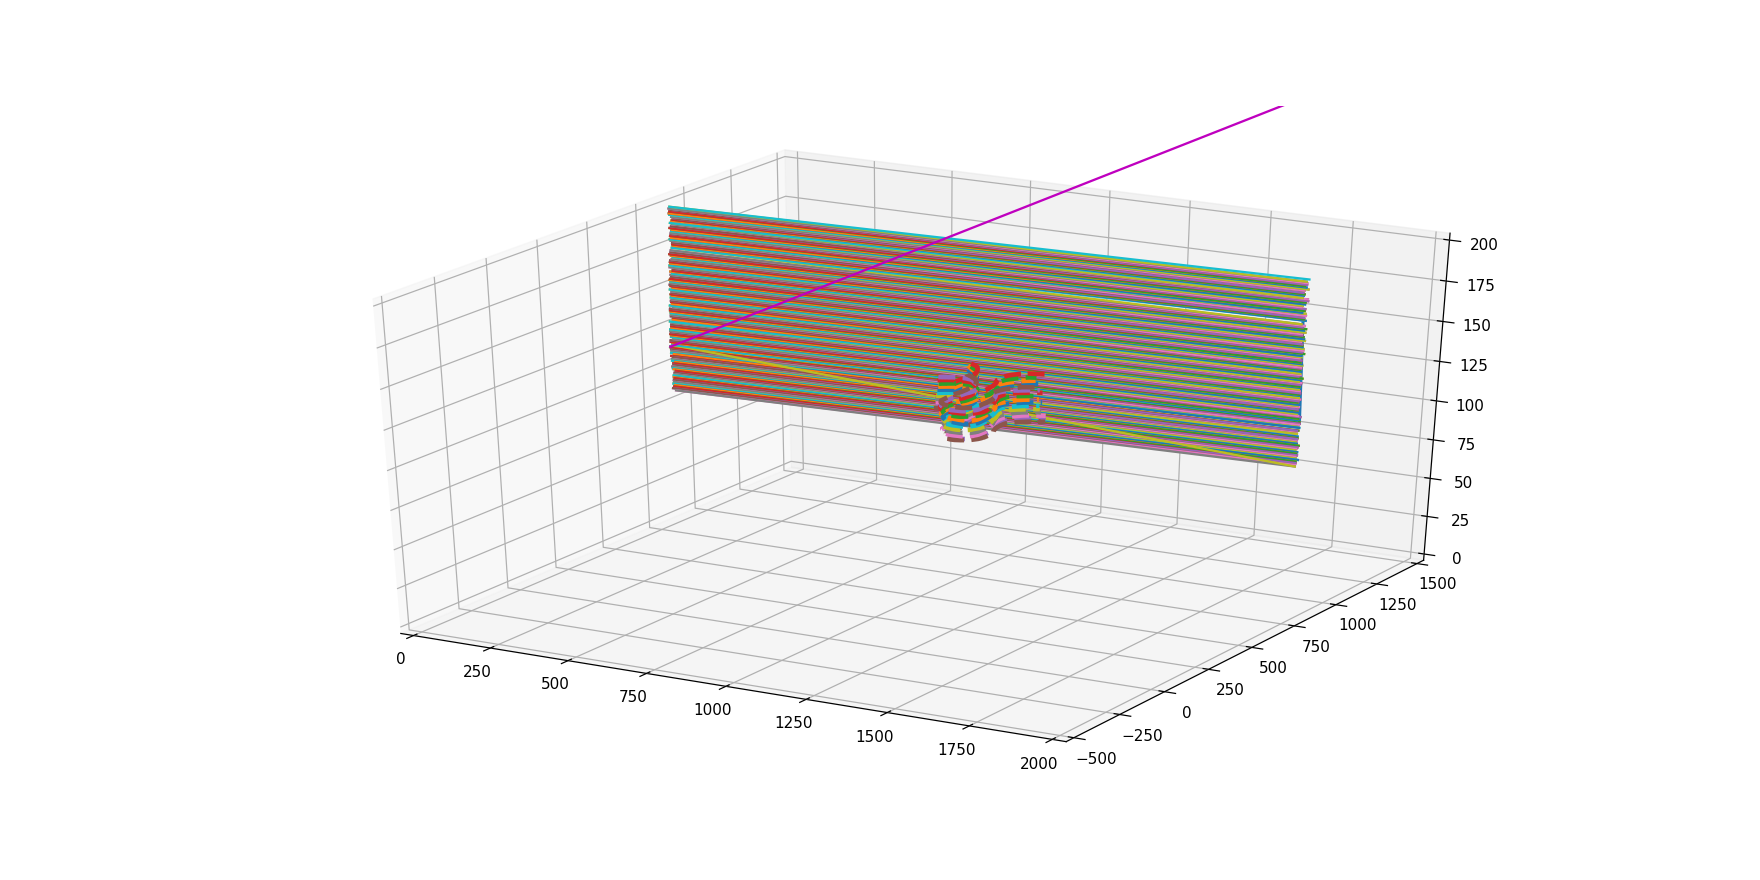

/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/c

In [13]:
# plot the nogo lines, membrane contour, and the plane defined by three lines from the nogo file

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=[16,8])
ax = fig.add_subplot(111, projection='3d')

ax.plot(xs=[xvals[0], xvals[1], xvals[-1]],ys =[yvals[0], yvals[1], yvals[-1]], zs = [zvals[0], zvals[1], zvals[-1]],linewidth=2)
for i in range(int(xvals.size/2)):
    ax.plot(xs=[xvals[i], xvals[i+1]],ys =[yvals[i], yvals[i+1]], zs = [zvals[i], zvals[i+1]])

for contourr in CCP['contour'].unique():
    cur_contour = CCP[CCP['contour']==contourr]
    ax.plot(xs=cur_contour['X'], ys=cur_contour['Y'], zs=cur_contour['Z'], linewidth=3,  linestyle = 'dashed')
    
ax.plot(xs = [x0, normal[0]], ys = [y0, normal[1]], zs = [z0, normal[2]], color="m")

plt.xlim([0,2000])
plt.ylim([-500,1500])
ax.set_zlim([0, 200])

plt.show()

    

# calculate directionality of filaments
## branched filaments here

In [14]:
ydirs=[]
zdirs=[]
all_filaments = []
filament_lengths = []

dot_products = []
relative_angles = []
normal_angles = []
relative_angles_90 = []
normal_vector = normal


for filament in selected_branched_coords.index.unique():
    cur_filament = selected_branched_coords[selected_branched_coords.index==filament]
    xx = cur_filament.X
    yy = cur_filament.Y
    zz = cur_filament.Z

    deltaxx = sum(np.diff(xx))
    deltayy = sum(np.diff(yy))
    deltazz = sum(np.diff(zz))
    
    fil_vector = (deltaxx, deltayy, deltazz)
    
#     np.dot(zz.iloc[-1],zz.iloc[0])
    fil_length = np.sqrt(deltaxx*deltaxx+deltayy*deltayy+deltazz+deltazz)

#     calculate the dot product with respect to the normal vector
#     normal_orientation_dp = np.dot(fil_vector, normal)

    # make sure they are unit vectors first
    
    unit_vector_1 = normal_vector / np.linalg.norm(normal_vector)
    unit_vector_2 = fil_vector / np.linalg.norm(fil_vector)
    
#     calculate the dot product bewtween these two vectors.
# NOTE that the sign may have to be manually determined in different datasets. 
# We don't know ahead of time whether the normal vector is pointing "up" or "down."
# so when plotting, we will check whether the value seems to be flipped or not. 
# We set the normal_directionality value (1 or -1) near the top of the notebook when setting the folder name
    
    dot_product = np.dot(unit_vector_1, unit_vector_2)*normal_directionality
    
#     relative_angle is the relative angle between the normal vector and the filament vector
#   starts at 0 and ends at 180

#     relative_angle = np.degrees((np.pi)-np.arccos(dot_product)) 
    relative_angle = np.degrees(np.arccos(dot_product))
    
#     relative_angle_90 starts at +90 and ends at -90 degrees
    relative_angle_90 = -np.degrees((np.arccos(dot_product)-(np.pi)/2)) 
   
#     we're not usig this value currently
    normal_angle = np.degrees(np.arccos(np.clip(dot_product, -1.0, 1.0)))

    
    dot_products.append(dot_product)
    
    relative_angles.append(relative_angle)
#     normal_angles.append(normal_angle)


# calculate orientation relative to the y axis plane (ydir) or z axis plane (zdir)
#     define direction theta such that 1 is up , 0 is parallel and -1 is down.
# arcsin(z/L)
#   take inverse so that + faces membrane (which is toward zero I think)
#     ydir = (deltayy/fil_length)
    ydir = np.degrees(np.arcsin(deltayy/fil_length))
   
    ydirs.append(ydir)
    
    zdir = np.degrees(-(np.arcsin(deltazz/fil_length)))
#     zdir = -np.arcsin(deltazz/fil_length)

    zdirs.append(zdir)
    
    filament_lengths.append(fil_length)
    
    cur_filament['ydir']=ydir
    cur_filament['zdir']=zdir
    cur_filament['length']=fil_length
    cur_filament['relative_angle'] = relative_angle
    cur_filament['relative_angle_90'] = relative_angle_90
    cur_filament['dot_product'] = dot_product
    all_filaments.append(cur_filament)
    
branched_filaments_df = pd.concat(all_filaments)
branched_filaments_df

/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

,X,Y,Z,ydir,zdir,length,relative_angle,relative_angle_90,dot_product
fil,,,,,,,,,
1,1239,581,224,30.403742,12.804269,302.317714,56.843794,33.156206,0.546923
1,1220,598,217,30.403742,12.804269,302.317714,56.843794,33.156206,0.546923
1,1191,624,210,30.403742,12.804269,302.317714,56.843794,33.156206,0.546923
1,1172,640,205,30.403742,12.804269,302.317714,56.843794,33.156206,0.546923
1,1138,667,199,30.403742,12.804269,302.317714,56.843794,33.156206,0.546923
...,...,...,...,...,...,...,...,...,...
14,1121,458,158,-49.242476,-9.561948,150.499169,135.038918,-45.038918,-0.707587
14,1092,424,166,-49.242476,-9.561948,150.499169,135.038918,-45.038918,-0.707587
14,1043,368,178,-49.242476,-9.561948,150.499169,135.038918,-45.038918,-0.707587


# Calculate orientation of unbranched Filaments


In [15]:
ydirs=[]
zdirs=[]
all_filaments = []
filament_lengths = []

dot_products = []
relative_angles = []
normal_angles = []
relative_angles_90 = []
normal_vector = normal

selected_ub_coords['min_end'] = selected_ub_coords['minus end point']
selected_ub_coords.min_end.replace(('first', 'last'), (1, -1), inplace=True)

for filament in selected_ub_coords.index.unique():
    cur_filament = selected_ub_coords[selected_ub_coords.index==filament]
    xx = cur_filament.X
    yy = cur_filament.Y
    zz = cur_filament.Z
#     calculate a directionality: -1 for minus end is the last point
#  and +1 for minus end is the first point
# this assumes that the orientation value is the same for all points on the filament

    ub_directionality = cur_filament.min_end.mean()
    
    deltaxx = sum(np.diff(xx))
    deltayy = sum(np.diff(yy))
    deltazz = sum(np.diff(zz))
    
    fil_vector = (deltaxx, deltayy, deltazz)
    
#     np.dot(zz.iloc[-1],zz.iloc[0])
    fil_length = np.sqrt(deltaxx*deltaxx+deltayy*deltayy+deltazz+deltazz)

#     calculate the dot product with respect to the normal vector
#     normal_orientation_dp = np.dot(fil_vector, normal)

    # make sure they are unit vectors first
    
    unit_vector_1 = normal_vector / np.linalg.norm(normal_vector)
    unit_vector_2 = fil_vector / np.linalg.norm(fil_vector)
    
#     calculate the dot product bewtween these two vectors.
# NOTE that the sign may have to be manually determined in different datasets. 
# We don't know ahead of time whether the normal vector is pointing "up" or "down."
# so when plotting, we will check whether the value seems to be flipped or not. 
# We set the normal_directionality value (1 or -1) near the top of the notebook when setting the folder name
    
    dot_product = np.dot(unit_vector_1, unit_vector_2)*normal_directionality*ub_directionality
    
#     relative_angle is the relative angle between the normal vector and the filament vector
#   starts at 0 and ends at 180

#     relative_angle = np.degrees((np.pi)-np.arccos(dot_product)) 
    relative_angle = np.degrees(np.arccos(dot_product))
    
#     relative_angle_90 starts at +90 and ends at -90 degrees
    relative_angle_90 = -np.degrees((np.arccos(dot_product)-(np.pi)/2)) 
   
#     we're not usig this value currently
    normal_angle = np.degrees(np.arccos(np.clip(dot_product, -1.0, 1.0)))

    
    dot_products.append(dot_product)
    
    relative_angles.append(relative_angle)
#     normal_angles.append(normal_angle)


# calculate orientation relative to the y axis plane (ydir) or z axis plane (zdir)
#     define direction theta such that 1 is up , 0 is parallel and -1 is down.
# arcsin(z/L)
#   take inverse so that + faces membrane (which is toward zero I think)
#     ydir = (deltayy/fil_length)
    ydir = np.degrees(np.arcsin(deltayy/fil_length))
   
    ydirs.append(ydir)
    
    zdir = np.degrees(-(np.arcsin(deltazz/fil_length)))
#     zdir = -np.arcsin(deltazz/fil_length)

    zdirs.append(zdir)
    
    filament_lengths.append(fil_length)
    
    cur_filament['ydir']=ydir
    cur_filament['zdir']=zdir
    cur_filament['length']=fil_length
    cur_filament['relative_angle'] = relative_angle
    cur_filament['relative_angle_90'] = relative_angle_90
    cur_filament['dot_product'] = dot_product
    all_filaments.append(cur_filament)
    
ub_filaments_df = pd.concat(all_filaments)
ub_filaments_df

/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

,X,Y,Z,minus end point,min_end,ydir,zdir,length,relative_angle,relative_angle_90,dot_product
fil,,,,,,,,,,,
2,984,721,127,first,1,66.864901,-15.405979,146.805994,24.476896,65.523104,0.910128
2,973,744,133,first,1,66.864901,-15.405979,146.805994,24.476896,65.523104,0.910128
2,964,766,140,first,1,66.864901,-15.405979,146.805994,24.476896,65.523104,0.910128
2,956,784,145,first,1,66.864901,-15.405979,146.805994,24.476896,65.523104,0.910128
2,949,799,150,first,1,66.864901,-15.405979,146.805994,24.476896,65.523104,0.910128
...,...,...,...,...,...,...,...,...,...,...,...
128,1378,338,151,first,1,21.803587,0.967371,177.693556,71.774520,18.225480,0.312757
130,1469,484,144,first,1,43.933862,-8.253353,83.594258,43.113313,46.886687,0.730003
130,1444,501,148,first,1,43.933862,-8.253353,83.594258,43.113313,46.886687,0.730003


# Orientation Plot Stuff From Other Notebook

<IPython.core.display.Javascript object>


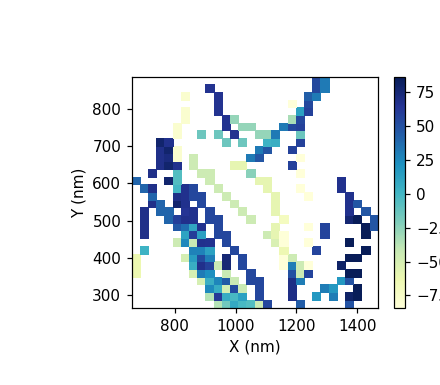

In [16]:
# branch angle  heat map XZ

fig = plt.figure(figsize=[4,3.5])
ax = fig.add_axes([0.3, 0.2, 0.7, 0.6])

plt.cm.get_cmap('PiYG')
# plt.set_cmap('PiYG')
plt.set_cmap('YlGnBu')



x = ub_filaments_df['X']
y = ub_filaments_df['Y']

color = ub_filaments_df['relative_angle_90']

bin_means, xedges, yedges, binnumbers = binned_statistic_2d(x, y, color, 
  bins=30, statistic='mean')
bin_means = np.flipud(np.rot90(bin_means))

# bin_means = bin_means/len(runs)/len(times)

plt.pcolormesh(xedges, yedges, bin_means)

plt.colorbar(label = 'Axial orientation')
plt.xlabel('X (nm)')
plt.ylabel('Y (nm)')
# plt.ylim([-200,0])
plt.show()

In [17]:
# plt.figure()
# plt.hist(relative_angles)
# # plt.show()

In [18]:
# take just the unique filaments (not every coordinate)
branched_filaments_unique = branched_filaments_df.groupby('fil').first()
ub_filaments_unique = ub_filaments_df.groupby('fil').first()


In [19]:
# save
branched_filaments_unique.to_csv(membrane_path+'branched_filaments_angles.csv')
ub_filaments_unique.to_csv(membrane_path+'unbranched_filaments_angles.csv')
# could just save the unique filaments and not every model point
branched_filaments_unique.head(10)

,X,Y,Z,ydir,zdir,length,relative_angle,relative_angle_90,dot_product
fil,,,,,,,,,
1,1239,581,224,30.403742,12.804269,302.317714,56.843794,33.156206,0.546923
3,1128,685,192,70.618245,30.825513,85.866175,35.128781,54.871219,0.817861
4,1223,607,208,81.253838,NaN,26.305893,59.439287,30.560713,0.508451
5,926,690,139,50.220991,20.521085,74.168727,46.750973,43.249027,0.685171
6,1121,548,189,35.371426,9.938077,278.125871,51.656143,38.343857,0.620380
7,844,755,152,29.932831,18.971385,132.268666,64.960333,25.039667,0.423246
8,810,789,156,-42.443417,-2.985278,460.835112,135.978254,-45.978254,-0.719076
9,1019,626,277,81.431486,2.491170,92.027170,12.495427,77.504573,0.976313
10,1012,664,278,20.545153,-2.234755,76.935038,65.901608,24.098392,0.408305


<IPython.core.display.Javascript object>


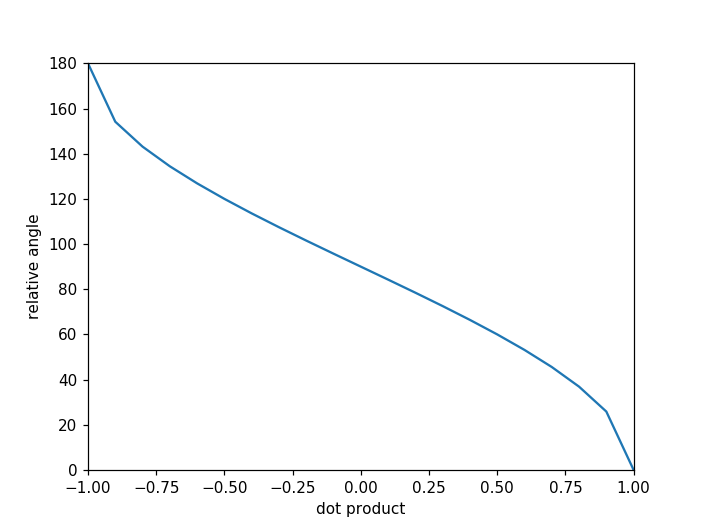

Text(0, 0.5, 'relative angle')

In [26]:
# just to check the relationship between dot product and angle

dots = np.arange(-1,1.1,0.1)
# thetas = 
# thetas = np.degrees((np.pi)-np.arccos(dots)) 
thetas = np.degrees(np.arccos(dots))

thetas_90 = -np.degrees((np.arccos(dots)-(np.pi)/2)) 

fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(dots,thetas)
plt.xlim([-1,1])
plt.ylim([0,180])
# plt.ylim([-90,90])
plt.xlabel('dot product')
plt.ylabel('relative angle')


In [22]:
# # hsv 75% colormap
# # https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
# # %matplotlib inline
# import matplotlib.colors as colors

# def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
#     new_cmap = colors.LinearSegmentedColormap.from_list(
#         'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
#         cmap(np.linspace(minval, maxval, n)))
#     return new_cmap

# cmap = plt.get_cmap('hsv')
# new_cmap = truncate_colormap(cmap, 0, 0.75)

In [22]:
# choose a colormap

import matplotlib.colors as colors
import matplotlib.cm as cmx

# colorss = cm = plt.get_cmap('bwr') 
# colorss = cm = plt.get_cmap('viridis') 
colorss = cm = plt.get_cmap('coolwarm') 


# colorss = cm = plt.get_cmap(new_cmap)
 
# cNorm  = colors.Normalize(vmin=0, vmax=values[-1])

# cNorm  = colors.Normalize(vmin=-90, vmax=90)

cNorm  = colors.Normalize(vmin=0, vmax=180)

# set colorlim to [-1 to 1]
# cNorm  = colors.Normalize(vmin=-1, vmax=1)

scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colorss)
print(scalarMap.get_clim())


(0.0, 180.0)


# plot unbranched filaments

<IPython.core.display.Javascript object>


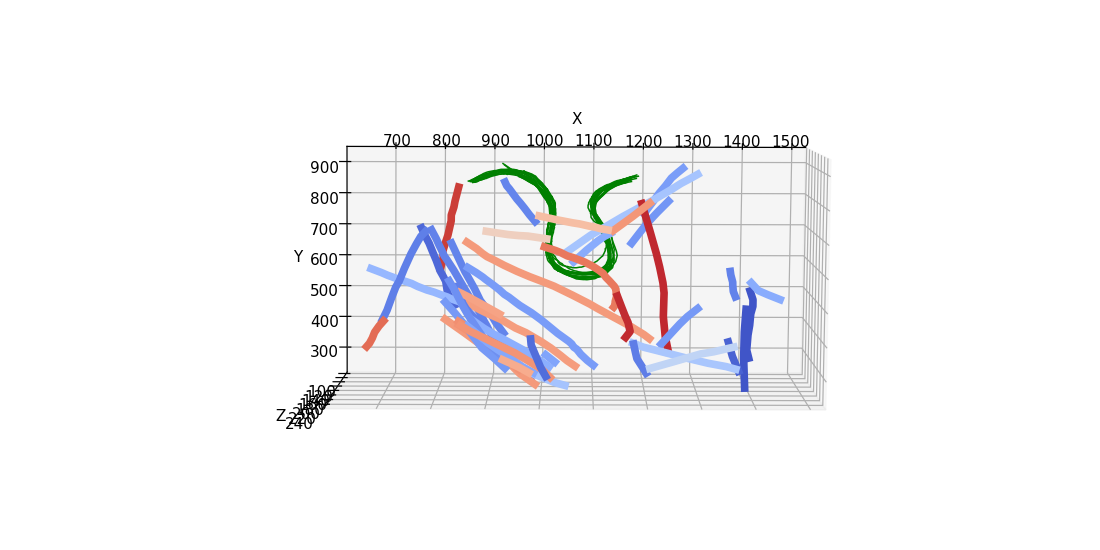

/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/c

Text(0.5, 0, 'Z')

In [23]:
# color code angles
# %matplotlib inline
from matplotlib import cm

# plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=[10,5])
# ax=fig.add_subplot(111, projection='3d')
ax=fig.gca(projection='3d')


# membrane

for contourr in CCP['contour'].unique():
    cur_contour = CCP[CCP['contour']==contourr]
    ax.plot(xs=cur_contour['X'], ys=cur_contour['Y'], zs=cur_contour['Z'], color='g', linewidth=1)

# for filament in all_filaments_df.index.unique():
#     cur_filament = all_filaments_df[all_filaments_df.index==filament]
# #     colorVal = scalarMap.to_rgba(cur_filament['ydir'])
#     colorVal = scalarMap.to_rgba(cur_filament['relative_angle'])
# #     colorVal = scalarMap.to_rgba(cur_filament['relative_angle_90'])
    
# #     colorVal = scalarMap.to_rgba(cur_filament['dot_product'])
    
#     ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], color=colorVal[0], linewidth=5)


for filament in ub_filaments_df.index.unique():
    cur_filament = ub_filaments_df[ub_filaments_df.index==filament]
#     colorVal = scalarMap.to_rgba(cur_filament['ydir'])
    colorVal = scalarMap.to_rgba(cur_filament['relative_angle'])
#     colorVal = scalarMap.to_rgba(cur_filament['relative_angle_90'])    
#     colorVal = scalarMap.to_rgba(cur_filament['dot_product'])
    
    ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], color=colorVal[0], linewidth=5)

    

# for filament in ub_all_filaments_df.index.unique():
#     cur_filament = ub_all_filaments_df[ub_all_filaments_df.index==filament]
#     colorVal = scalarMap.to_rgba(cur_filament['ydir'])
#     ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], color=colorVal[0], linewidth=5)
    
# plt.xlim([500,1400])
# plt.ylim([350,950])
# ax.set_zlim([50,250])

# ax.set_xticks(np.arange(500,1400,100))
# ax.set_yticks(np.arange(400,1000,100))
# ax.set_zticks([100,200])
# cbar = fig.colorbar(colorVal,ax=ax)
# fig.colorbar(p)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Plot branched filament orientations 

<IPython.core.display.Javascript object>


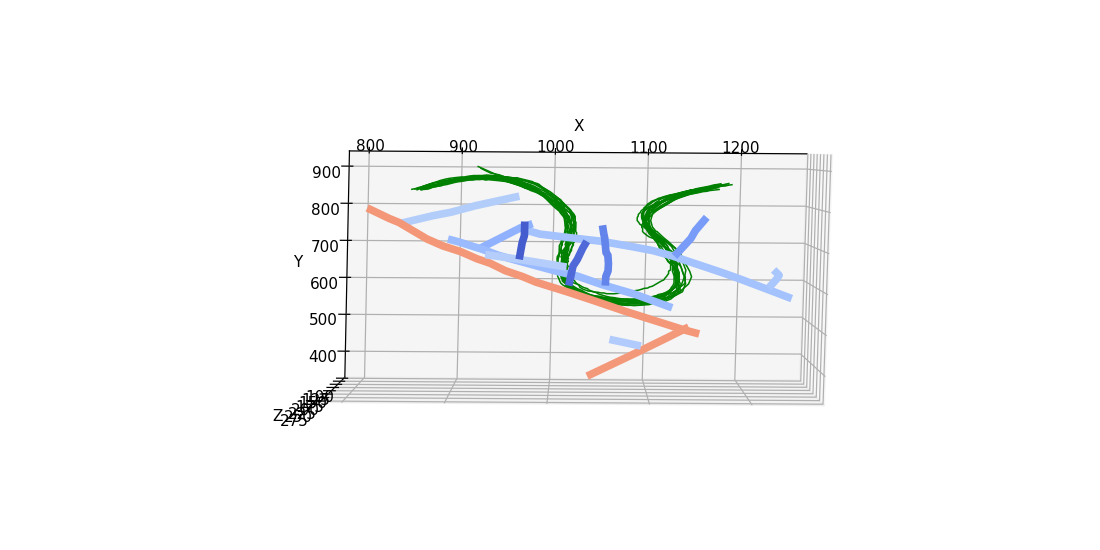

/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/c

Text(0.5, 0, 'Z')

In [24]:
# color code angles
# %matplotlib inline
from matplotlib import cm

# plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=[10,5])
# ax=fig.add_subplot(111, projection='3d')
ax=fig.gca(projection='3d')


# membrane

for contourr in CCP['contour'].unique():
    cur_contour = CCP[CCP['contour']==contourr]
    ax.plot(xs=cur_contour['X'], ys=cur_contour['Y'], zs=cur_contour['Z'], color='g', linewidth=1)

for filament in branched_filaments_df.index.unique():
    cur_filament = branched_filaments_df[branched_filaments_df.index==filament]
#     colorVal = scalarMap.to_rgba(cur_filament['ydir'])
    colorVal = scalarMap.to_rgba(cur_filament['relative_angle'])
#     colorVal = scalarMap.to_rgba(cur_filament['relative_angle_90'])
    
#     colorVal = scalarMap.to_rgba(cur_filament['dot_product'])
    
    ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], color=colorVal[0], linewidth=5)


# for filament in ub_filaments_df.index.unique():
#     cur_filament = ub_filaments_df[ub_filaments_df.index==filament]
# #     colorVal = scalarMap.to_rgba(cur_filament['ydir'])
#     colorVal = scalarMap.to_rgba(cur_filament['relative_angle'])
# #     colorVal = scalarMap.to_rgba(cur_filament['relative_angle_90'])    
# #     colorVal = scalarMap.to_rgba(cur_filament['dot_product'])
    
#     ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], color=colorVal[0], linewidth=5)

    

# for filament in ub_all_filaments_df.index.unique():
#     cur_filament = ub_all_filaments_df[ub_all_filaments_df.index==filament]
#     colorVal = scalarMap.to_rgba(cur_filament['ydir'])
#     ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], color=colorVal[0], linewidth=5)
    
# plt.xlim([500,1400])
# plt.ylim([350,950])
# ax.set_zlim([50,250])

# ax.set_xticks(np.arange(500,1400,100))
# ax.set_yticks(np.arange(400,1000,100))
# ax.set_zticks([100,200])
# cbar = fig.colorbar(colorVal,ax=ax)
# fig.colorbar(p)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# end! the rest is just draft material

In [60]:
# save CCP membrane coordinates
CCP=CCP.reset_index().set_index(['object','contour'])

CCP.to_pickle('CCP_membrane_coordinates.pkl')
CCP

index    X     Y    Z
object contour                       
1      1            0  847  1455  160
       1            1  851  1456  160
       1            2  857  1458  160
       1            3  859  1459  160
       1            4  862  1460  160
...               ...  ...   ...  ...
       22        2074  846  1444  200
       22        2075  851  1444  200
       22        2076  859  1447  200
       22        2077  862  1447  200
       22        2078  865  1447  200

[2079 rows x 4 columns]

In [61]:
# import 3D meshing of membrane made by "symmetrecized plotting.ipynb"
import pickle as pkl
cur_mesh = pkl.load(open('rotate_obj.pkl','rb'))
cur_mesh

FileNotFoundError: [Errno 2] No such file or directory: 'rotate_obj.pkl'

<IPython.core.display.Javascript object>


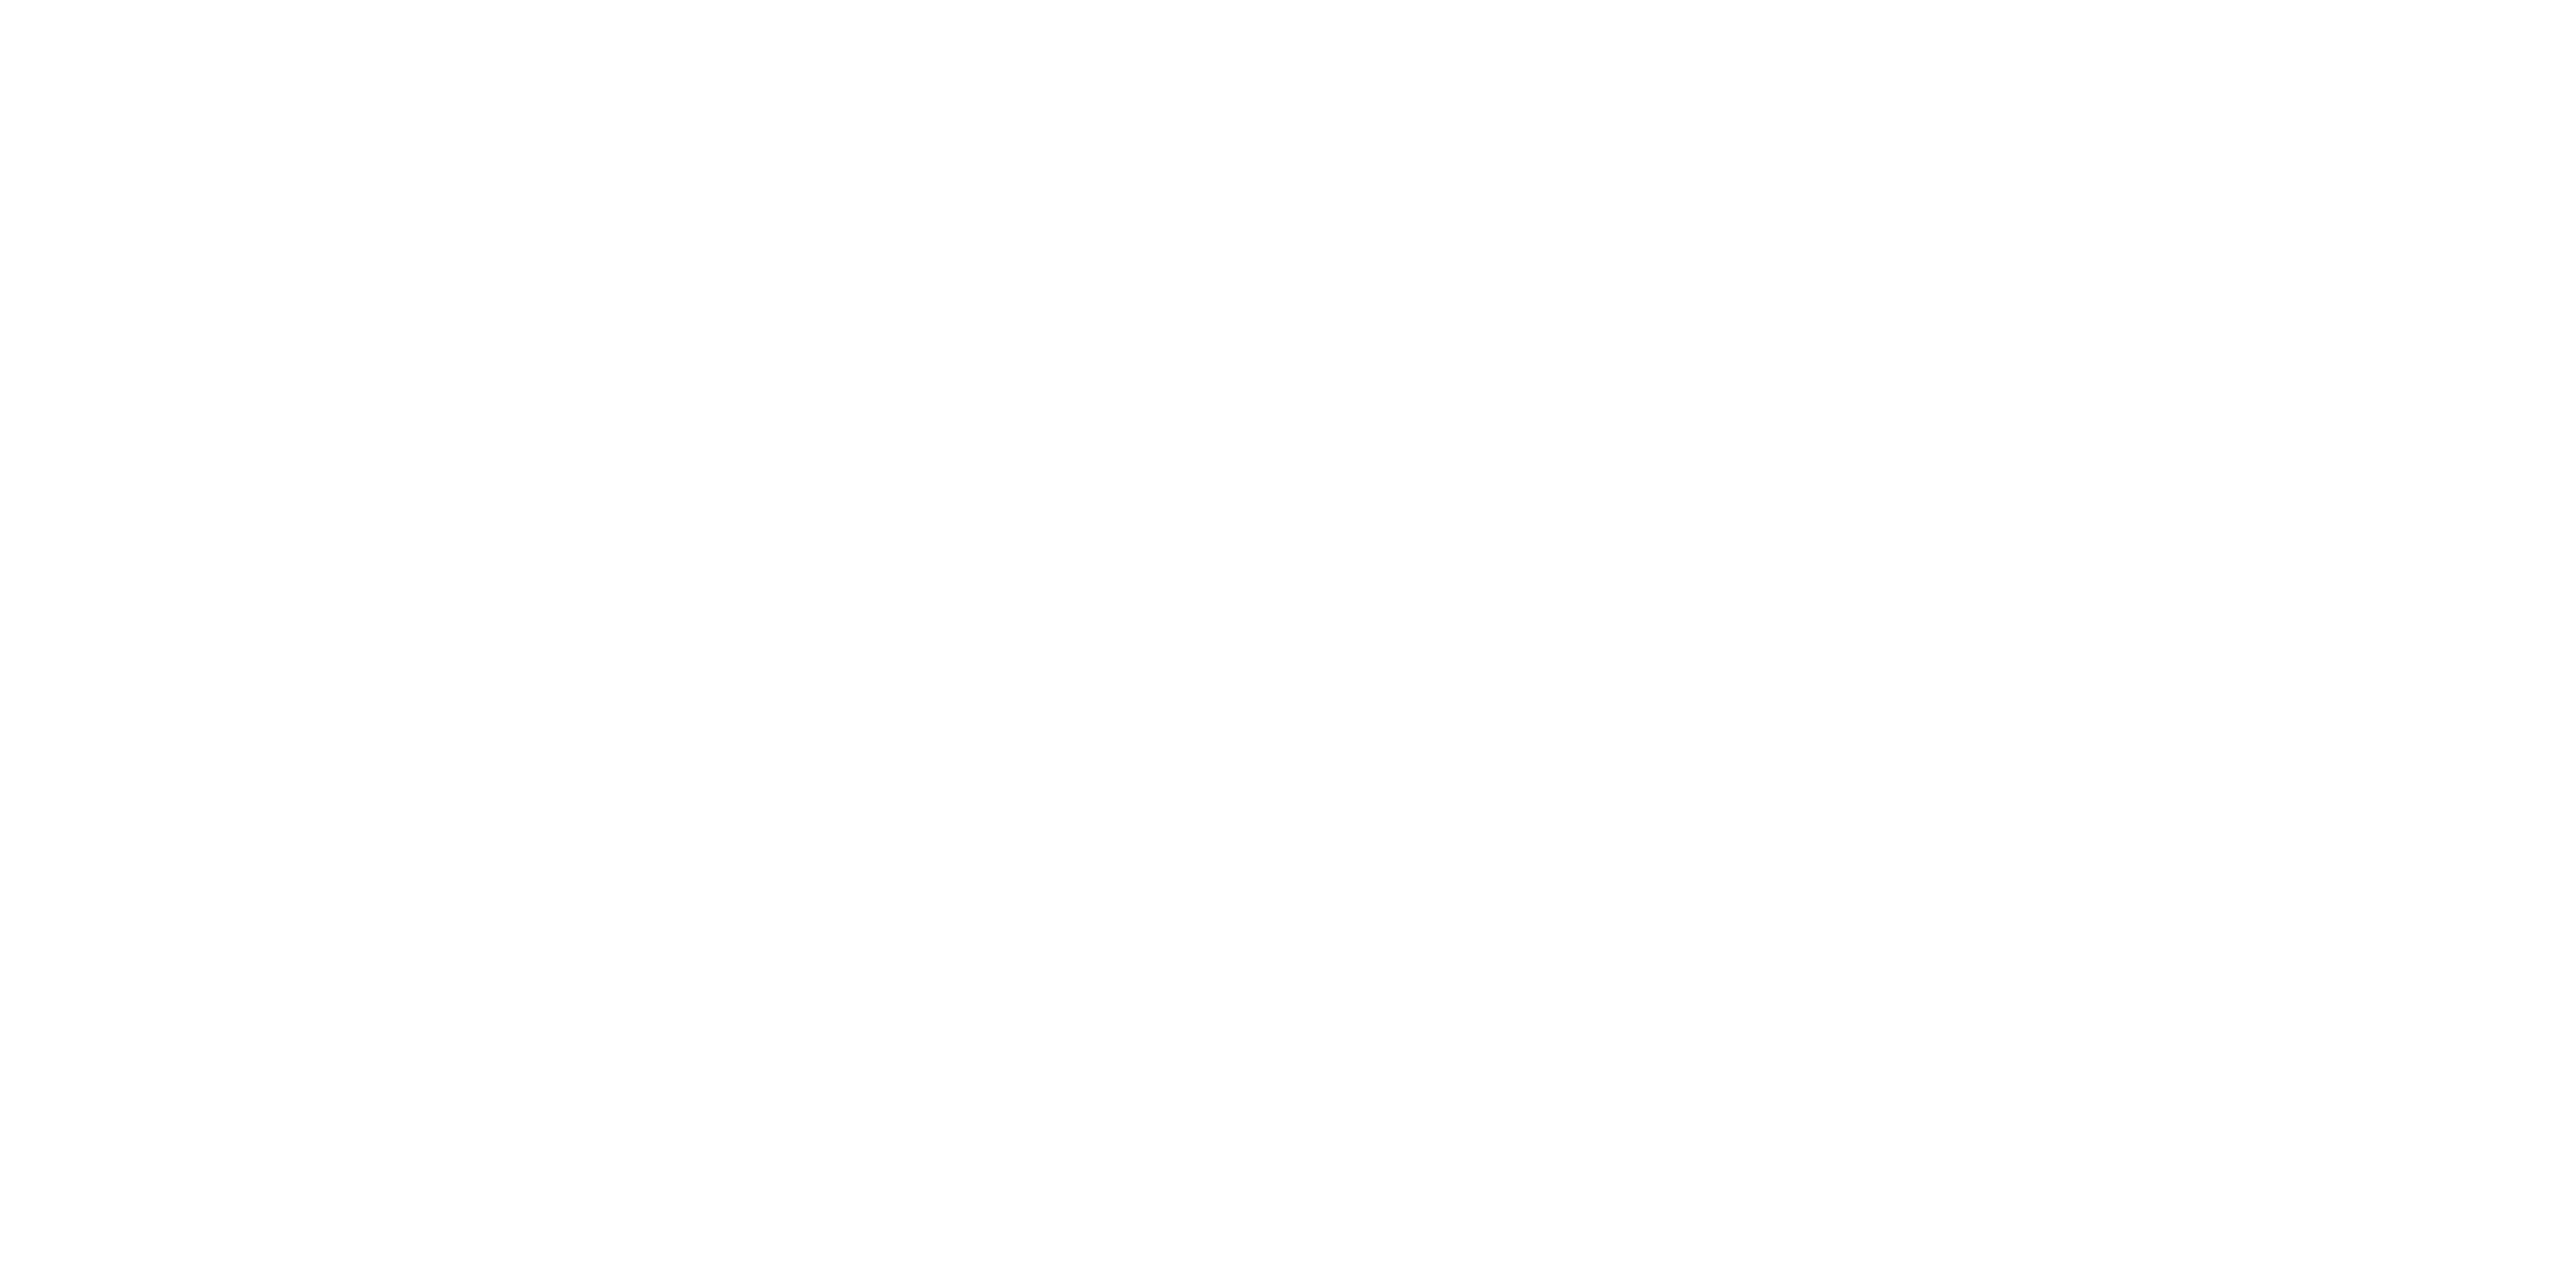

NameError: name 'cur_mesh' is not defined

In [62]:
# plot

fig = plt.figure(figsize=[20,10])
ax=fig.add_subplot(111, projection='3d')

# membrane
ax.plot_surface(cur_mesh.x3d,cur_mesh.y3d, cur_mesh.z3d, color='g', alpha=0.5)

# filaments

for filament in all_filaments_df.index.unique():
    cur_filament = all_filaments_df[all_filaments_df.index==filament]
    colorVal = scalarMap.to_rgba(cur_filament['ydir'])
    ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], color=colorVal[0], linewidth=5)
    
# plt.xlim([500,1400])
# plt.ylim([350,950])
# ax.set_zlim([50,250])

# ax.set_xticks(np.arange(500,1400,100))
# ax.set_yticks(np.arange(400,1000,100))
# ax.set_zticks([100,200])


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


# with actin

In [ ]:
# # arrowheads??
# # https://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot
# import numpy as np
# from numpy import *
# from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.patches import FancyArrowPatch
# from mpl_toolkits.mplot3d import proj3d

# class Arrow3D(FancyArrowPatch):
#     def __init__(self, xs, ys, zs, *args, **kwargs):
#         FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
#         self._verts3d = xs, ys, zs

#     def draw(self, renderer):
#         xs3d, ys3d, zs3d = self._verts3d
#         xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
#         self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
#         FancyArrowPatch.draw(self, renderer)


In [29]:
# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(111, projection='3d')

# a = Arrow3D(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], mutation_scale=20, 
#                 lw=3, arrowstyle="-|>", color="r")
# ax.add_artist(a)


## color code each segment